## NLA project 2019:
###    Feature Ranking via Eigenvector Centrality

Team members:
- Aleksandr Belov
- Ivan Baybuza
- Mariia Kopylova
- Miron Kuznetsov

In [1]:
import re
import os
import json

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz, load_npz

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH_TO_DATA = '../data/Results_full_04.12.csv'


DATE_RE = re.compile(r'\d{1,2}\.\d{1,2}\.\d{4}')
DROP_COLUMNS = ['updated_link', 'sex']

NAN_LABEL = 'NaN'

In [3]:
def extract_date(text):
    if not isinstance(text, str):
        return None

    matches = DATE_RE.search(text)
    return None if matches is None else matches.group(0)


def text_process(x):
    if pd.isna(x):
        return x

    if isinstance(x, str):
        return x

    raise TypeError(f'Invalid type: {type(x)}')


def float_process(x):
    if isinstance(x, str):
        x = x.replace(' ', '')
        x = x.replace(',', '.')
        x = x if x.replace('.', '', 1).isdigit() else 0

    return np.float64(x)


def ara_process(x):
    if isinstance(x, str):
        return x.startswith('лозартан')
    if pd.isna(x):
        return x

    raise TypeError(f'Invalid type: {type(x)}')


def war_process(x):
    if isinstance(x, str):
        return x.startswith('варфар')
    if pd.isna(x):
        return x

    raise TypeError(f'Invalid type: {type(x)}')


def nan_process(x):
    if pd.isna(x):
        return x
        x = NAN_LABEL

    return str(x)


def range_process(x, values):

    if pd.isna(x):
        return x
        return NAN_LABEL

    for i in range(len(values)-1):
        if values[i] < x <= values[i+1]:
            return f'<={values[i+1]}'

    return f'>{values[-1]}'


def age_process(x):
    ages = [0, 40, 50, 60, 70, 80]
    return range_process(x, ages)


def left_heart_process(x):
    values = [0, 3.2, 3.5, 3.7, 4, 4.5]
    return range_process(x, values)


def ara2_dose_process(x):
    doses = [0, 24, 25, 50]
    return range_process(x, doses)


def mass_process(x):
    masses = [0, 22, 26, 30, 33, 40]
    return range_process(x, masses)


def diurectic_dose_process(x):
    doses = [0, 1.5, 7, 20, 25, 40]
    return range_process(x, doses)


def war_dose_process(x):
    doses = [0, 2.4, 2.7]
    return range_process(x, doses)


def diurectic_process(x):

    if pd.isna(x):
        return x

    starts = ['альдакт', 'арифон', 'ацетазолам', 'бритом', 'верошпир', 'гидрохлортиаз', 
              'диакар', 'диувер', 'индапам', 'инспр', 'лазик', 'равел', 'спиронолакт',
              'торасем', 'тригр', 'урегит', 'фуросем', 'хлорталид', 'эплерен', 'эспир']

    for s in starts:
        if x.startswith(s):
            return s

    return x

# 1. Data

In [4]:
df = pd.read_csv(PATH_TO_DATA, index_col=0)

/Users/aleksandr.belov/work/tools/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9,10,11,12,15,16,18,21,22,23,24,25,28,29,30,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#df.head()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165587 entries, 0 to 165586
Data columns (total 34 columns):
id                 165587 non-null int64
doc_id             165587 non-null int64
case_history_id    165587 non-null int64
creation_date      165587 non-null object
update_date        165587 non-null object
doc_type           165587 non-null object
sex_given          165587 non-null object
patient_id         165587 non-null int64
updated_link       84581 non-null object
Sin                77835 non-null object
Sin_date           48632 non-null object
PI48               84578 non-null object
sex                95006 non-null object
age                84579 non-null float64
cad                84578 non-null object
hyp                84578 non-null object
mass_index         59732 non-null float64
heart_failure      84578 non-null object
diabetes           165587 non-null bool
tromb              84578 non-null float64
VD                 84578 non-null object
PAD                845

In [7]:
df = df.drop(columns=DROP_COLUMNS)

# 2. Preprocessing

In [8]:
df.creation_date = pd.to_datetime(df.creation_date)
df.update_date = pd.to_datetime(df.update_date)

df.Sin_date = df.Sin_date.apply(extract_date)
df.Sin_date = pd.to_datetime(df.Sin_date, errors='coerce')

In [9]:
df.Sin = df.Sin.apply(nan_process)
df.PI48 = df.PI48.apply(nan_process)
df.cad = df.cad.apply(nan_process)
df.hyp = df.hyp.apply(nan_process)
df.heart_failure = df.heart_failure.apply(nan_process)
df.tromb = df.tromb.apply(nan_process)
df.VD = df.VD.apply(nan_process)
df.PAD = df.PAD.apply(nan_process)
df.stroke = df.stroke.apply(nan_process)
df.TIA_1 = df.TIA_1.apply(nan_process)
df.systTR = df.systTR.apply(nan_process)

In [10]:
df.left_heart = df.left_heart.apply(float_process)

df.ara2 = df.ara2.apply(text_process)
df.ara2 = df.ara2.apply(ara_process)
df.ara2_dose = df.ara2_dose.apply(float_process)

df.diuretic = df.diuretic.apply(text_process)
df.diuretic_dose = df.diuretic_dose.apply(float_process)

df.war = df.war.apply(text_process)
df.war = df.war.apply(war_process)
df.war_dose = df.war_dose.apply(float_process)

In [11]:
df.age = df.age.apply(age_process)
df.mass_index = df.mass_index.apply(mass_process)
df.left_heart = df.left_heart.apply(left_heart_process)
df.ara2_dose = df.ara2_dose.apply(ara2_dose_process)
df.diuretic = df.diuretic.apply(diurectic_process)
df.diuretic_dose = df.diuretic_dose.apply(diurectic_dose_process)
df.war_dose = df.war_dose.apply(war_dose_process)

# 3. Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165587 entries, 0 to 165586
Data columns (total 32 columns):
id                 165587 non-null int64
doc_id             165587 non-null int64
case_history_id    165587 non-null int64
creation_date      165587 non-null datetime64[ns]
update_date        165587 non-null datetime64[ns]
doc_type           165587 non-null object
sex_given          165587 non-null object
patient_id         165587 non-null int64
Sin                77835 non-null object
Sin_date           18342 non-null datetime64[ns]
PI48               84578 non-null object
age                84579 non-null object
cad                84578 non-null object
hyp                84578 non-null object
mass_index         59732 non-null object
heart_failure      84578 non-null object
diabetes           165587 non-null bool
tromb              84578 non-null object
VD                 84578 non-null object
PAD                84578 non-null object
stroke             84578 non-null object
T

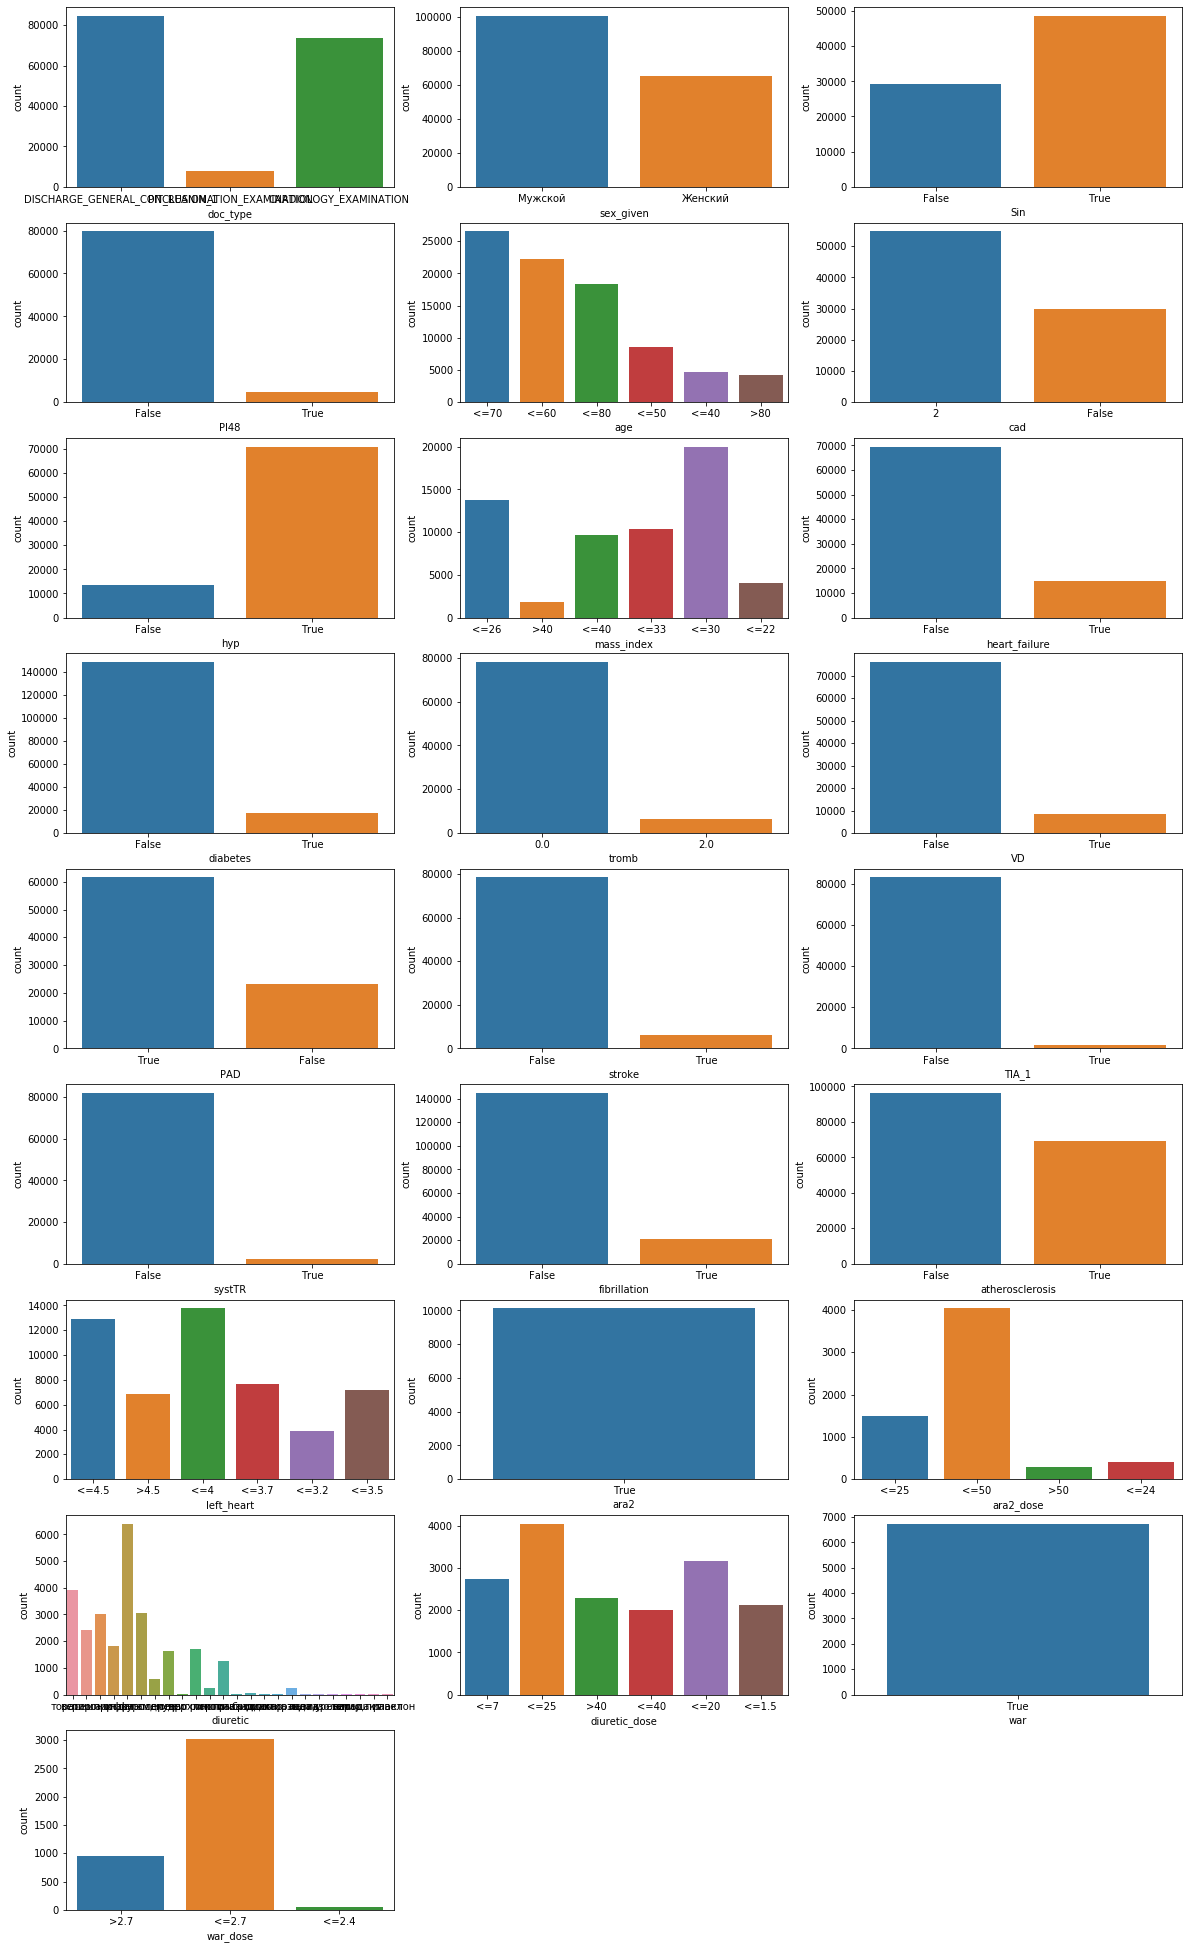

In [13]:
column_names = ['doc_type', 'sex_given', 'Sin', 'PI48', 'age', 'cad', 
                'hyp', 'mass_index', 'heart_failure', 'diabetes', 'tromb', 
                'VD', 'PAD', 'stroke', 'TIA_1', 'systTR', 'fibrillation', 
                'atherosclerosis', 'left_heart', 'ara2', 'ara2_dose', 
                'diuretic', 'diuretic_dose', 'war', 'war_dose']

plt.figure(figsize=(20, 35))

for i, col in enumerate(column_names, 1):
    plt.subplot(9, 3, i)
    order = df[col].unique()
    sns.countplot(x=col, data=df)

# 4. Convert to OneHotEncode

In [14]:
target_name = 'fibrillation'

feature_columns = column_names.copy()
feature_columns.remove(target_name)

In [15]:
def one_hot_encode_features(df, feature_columns, is_sparse=True):
    oh_df = pd.DataFrame()

    for fn in feature_columns:
        dummy_f = pd.get_dummies(df[fn], prefix=fn)
        oh_df = pd.concat((oh_df, dummy_f), axis=1)

    feature_names = oh_df.columns
    feature_names = np.asarray(feature_names)
    
    if is_sparse:
        return csr_matrix(oh_df.values), feature_names
    else:
        return oh_df, feature_names


def get_sparse_target(df, target_name):
    target = df[target_name].astype(np.uint8).values
    return csr_matrix(target)

In [16]:
X, feature_names = one_hot_encode_features(df, feature_columns)
target = get_sparse_target(df, target_name)

In [17]:
print(repr(X))
print(repr(target))

<165587x88 sparse matrix of type '<class 'numpy.uint8'>'
	with 1852619 stored elements in Compressed Sparse Row format>
<1x165587 sparse matrix of type '<class 'numpy.uint8'>'
	with 20644 stored elements in Compressed Sparse Row format>


# Eigenvector Centrality Feature Selection

In [18]:
X = X.toarray()
target = target.toarray().flatten()

In [19]:
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

In [20]:
def fisher_score(X, y):
    mu_pos = X[y==1].mean(axis=0)
    mu_neg = X[y==0].mean(axis=0)
    std_pos = X[y==1].std(axis=0)
    std_neg = X[y==0].std(axis=0)

    fs = (mu_pos - mu_neg)**2 / (std_pos**2 + std_neg**2)
    return fs


def compute_max_stds(X):
    n_features = X.shape[1]
    max_stds = np.zeros((n_features, n_features))
    std = X.std(axis=0)

    max_stds = [[max(si, sj) for si in std] for sj in std]
    return np.asarray(max_stds)


def create_A(X, y, alpha=0.5):
    mutual_score = [mutual_info_score(X[:, i], y) for i in range(X.shape[1])]
    fs = fisher_score(X, y)
    kernel = np.outer(fs, mutual_score)

    max_std = compute_max_stds(X)
    A = alpha*kernel + (1-alpha)*max_std
    return A

In [21]:
def power_method(A, x0, num_iter):
    res = np.zeros(num_iter)
    x0 /= np.linalg.norm(x0)

    for i in range(num_iter):
        x = A @ x0
        l = x @ x0

        res[i] = np.linalg.norm(x - l*x0)
        x0 = x / np.linalg.norm(x)

    return x0, l, res

In [22]:
%%time
A = create_A(X, target)
v, _, _ = power_method(A, np.ones(A.shape[0]), 10)
ranks = v[0]

CPU times: user 1.35 s, sys: 250 ms, total: 1.6 s
Wall time: 1.38 s


In [23]:
iters = 10
residuals = []

for _ in range(iters):
    num_iter = 10
    x0 = np.random.rand(A.shape[0])
    _, _, res = power_method(A, x0, num_iter)
    residuals.append(res)

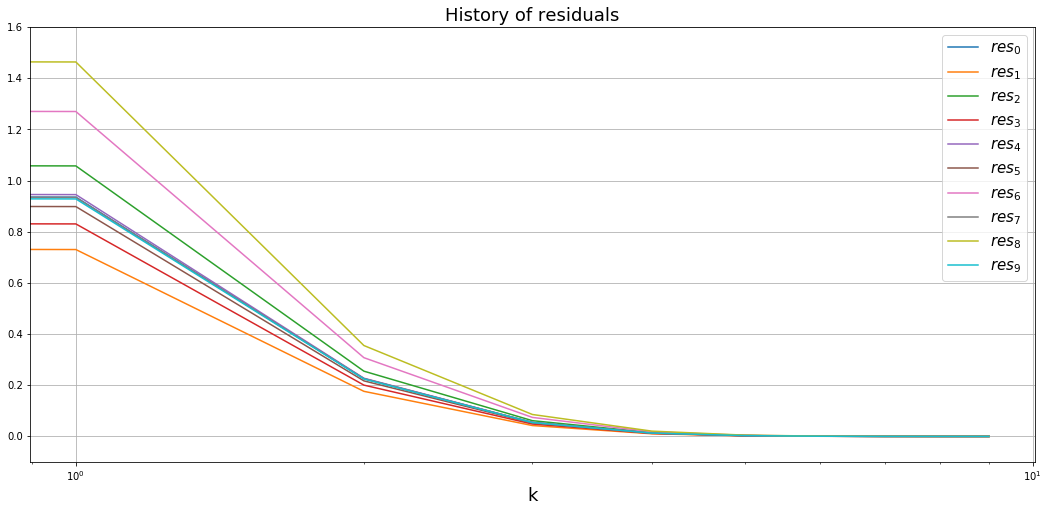

In [24]:
plt.figure(figsize=(18, 8))
for i, res in enumerate(residuals):
    plt.plot(res, label=fr'$res_{i}$')
    
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('k', fontsize=18)
plt.title('History of residuals', fontsize=18)
plt.xscale('log')
plt.ylim([-0.1, 1.6])
plt.show()

In [25]:
scaled_ranks = MinMaxScaler().fit_transform(ranks[:, np.newaxis]).flatten()
norm_ranks = scaled_ranks / scaled_ranks.sum()

In [26]:
sorted_i = np.argsort(norm_ranks)[::-1]

top_n = 30

top_fi = norm_ranks[sorted_i[:top_n]]
top_fn = feature_names[sorted_i[:top_n]]

for j, fn in enumerate(top_fn, 1):
    print(f'{j})', fn, f'{top_fi[j-1]:.3f}')

1) left_heart_<=3.7 0.022
2) left_heart_<=3.5 0.021
3) diuretic_диакар 0.019
4) left_heart_<=4 0.019
5) Sin_False 0.018
6) diuretic_бритом 0.015
7) mass_index_<=40 0.014
8) diuretic_ацетазолам 0.014
9) mass_index_<=22 0.014
10) left_heart_<=3.2 0.014
11) PAD_True 0.013
12) VD_True 0.013
13) diabetes_True 0.013
14) mass_index_>40 0.013
15) systTR_True 0.012
16) sex_given_Женский 0.012
17) Sin_True 0.012
18) TIA_1_False 0.012
19) age_<=70 0.012
20) PI48_False 0.012
21) diuretic_спиронолакт 0.012
22) PAD_False 0.012
23) ara2_dose_>50 0.012
24) diuretic_торасем 0.012
25) diuretic_индапам 0.012
26) sex_given_Мужской 0.012
27) mass_index_<=30 0.012
28) atherosclerosis_True 0.011
29) diuretic_верошпир 0.011
30) age_<=50 0.011


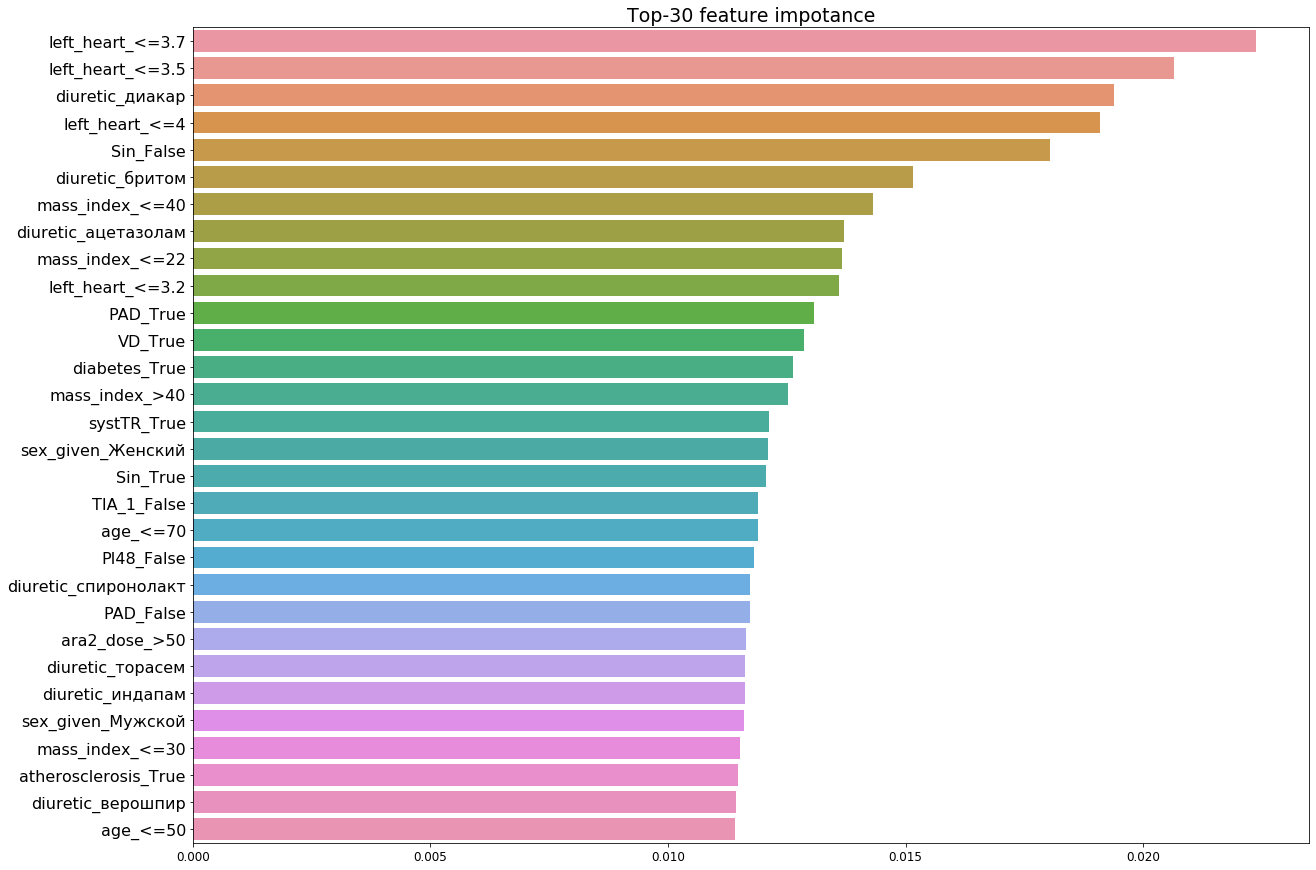

In [27]:
plt.figure(figsize=(20, 15))
sns.barplot(top_fi,  top_fn, orient='h')
plt.title('Top-30 feature impotance', fontsize=19)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=16)